# Project: Train a Quadcopter How to Hover

Design an agent to fly a quadcopter, and then train it using a reinforcement learning algorithm to stay still in a target position.

## Files

The files in the directory to better understand the structure of the project. 

- `task.py`: Task (environment) with reward function.
- `agents/DDPG.py`: Reinforcement learning agent.
- `physics_sim.py`: Simulator for the quadcopter.

## Controlling the Quadcopter

The Reinforcement Learning Model is the Deep Deterministic Policy Gradients ([DDPG](https://arxiv.org/abs/1509.02971)). Different parameters were tried for the setting of the neural networks (ammount of hidden layers, nodes, ...) and hyperparameters. The best tuning was achieved with:
- [Ornstein-Uhlenbeck](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process) noise process for exploration, $\mu$ = 405, $\theta$ = 0.915, $\sigma$ = 0.01
- Random sampling memory for batch learning with memmory `buffer_size = 1e6`, minimum buffer lenght of 64 for learning, $\gamma$ = 0.99, $\tau$ = 0.901;
- Agent Neural Network: 3 hidden layers (32, 300 and 400 nodes) with relu/sigmoid activations and `lr=0.0001` for Adam optimizer; and
- Critic Neural Network: 2 hidden layers (32 and 300) for both action and state pathways, with relu/sigmoid activations and `lr=0.00001` for Adam optimizer.

The agent controls the quadcopter by setting the revolutions per second on each of its four rotors.  The agent in the `DDPG` class always selects an action based on a neural network that is retrained in each step of the simulation.  These four speeds are returned by the `act` method as a list of four floating-point numbers.

## The Task

The task to be performed is to steadily hover in the target position.

In order to achieve it, the reward function is designed with constant gain of 1.0 every step but with punishments subtractions for:
- position away from the target (translation error);
- velocity different than zero (non-static state); and
- angular velocity different than zero (rotational state).

The score is defined as the total of rewards in the episode normalized by the count of total steps. Consdiering that the reward is `1.0 - punishments`, the score value is in the range (-$\infty$ 1.0]. This design makes it easier to compare different models and parameters.

The `task.py` file contains information about the mission to be accomplished by the quadcopter.

The `__init__()` method is used to initialize several variables that are needed to specify the task.  
- The simulator is initialized as an instance of the `PhysicsSim` class (from `physics_sim.py`).
- The state vector is only 6-dimensional with pose information (position and attitude). However, `action_repeat=3` considers that learning and recalculating different actions will be performed every 3 steps (`state_size=6*3`). It is remarked that for the agent the state vector excludes the velocity and acceleration information as opposition of the traditional spacecraft control. 
- The environment will always have a 4-dimensional action space, with one entry for each rotor (`action_size=4`). The minimum (`action_low=0`) and maximum (`action_high=900`) values are set to respect the physical actuators constrains.

The `reset()` method resets the simulator.  The agent should call this method every time the episode ends.  You can see an example of this in the code cell below.

The `step()` method is perhaps the most important.  It accepts the agent's choice of action `rotor_speeds`, which is used to prepare the next state to pass on to the agent.  Then, the reward is computed from `get_reward()`.  The episode is considered done if the time limit has been exceeded, or the quadcopter has travelled outside of the bounds of the simulation.

In [50]:
from agents.DDPG import DDPG as Agent
from task import Task
%load_ext autoreload
%autoreload 2

import csv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

num_episodes = 1000
target_pos = np.array([0., 0., 10.])
init_pose = np.array([0., 0., 10., .0, .0, .0])
task = Task(target_pos=target_pos, init_pose=init_pose, runtime=1.0)
agent = Agent(task)
best_score = -float('inf')

labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4', 'reward']
labels_episodes = ['i_episode', 'sim_time', 'score', 'best_score']
episodes = {x : [] for x in labels_episodes}

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    results = {x : [] for x in labels}

    while True:
        action = agent.act(state, explore=True) 
        next_state, reward, done = task.step(action)
        agent.step(action, reward, next_state, done)
        state = next_state
        
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) +
            list(task.sim.angular_v) + list(action) + list([reward])
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
            
        if done:
            if agent.score > best_score:
                best_flight = results
                best_score = agent.score
            print("\rEpisode = {:4d}, time = {:4.2f}, score = {:4.3f}, best score = {:4.3f}".format(
                i_episode, task.sim.time, agent.score, best_score), end="")  # [debug]
            to_write = [i_episode] + [task.sim.time] + [agent.score] + [best_score]
            for ii in range(len(labels_episodes)):
                episodes[labels_episodes[ii]].append(to_write[ii])
            break
    sys.stdout.flush()

Episode = 1000, time = 1.02, score = 0.991, best score = 0.9941904

## Plot the Scores

Check the learning performance over the episodes.

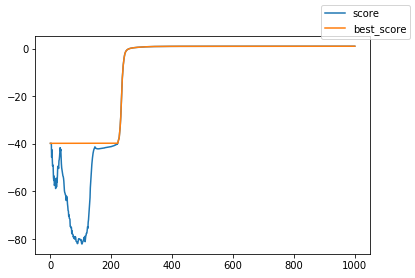

In [51]:
fig, ax1 = plt.subplots()
ax1.plot(episodes['i_episode'], episodes['score'], label='score')
ax1.plot(episodes['i_episode'], episodes['best_score'], label='best_score')
fig.legend()

The episode rewards are gradually increasing, indicating that the agent is learning. The learning rate is quite steep since the reward is almost maximum before the 300th episode. There was no 'a-ha' moment, *au contraire*, the learning was gradual since the beginning. The mean reward over the last 10 episodes is also quite satisfactory: steadily over 0.99 (1.0 maximum).

## Plot the Best Flight

Now that the agent is well trained, we can vizualize its best flight to check if it accomplishes the hover task in the target position properly.

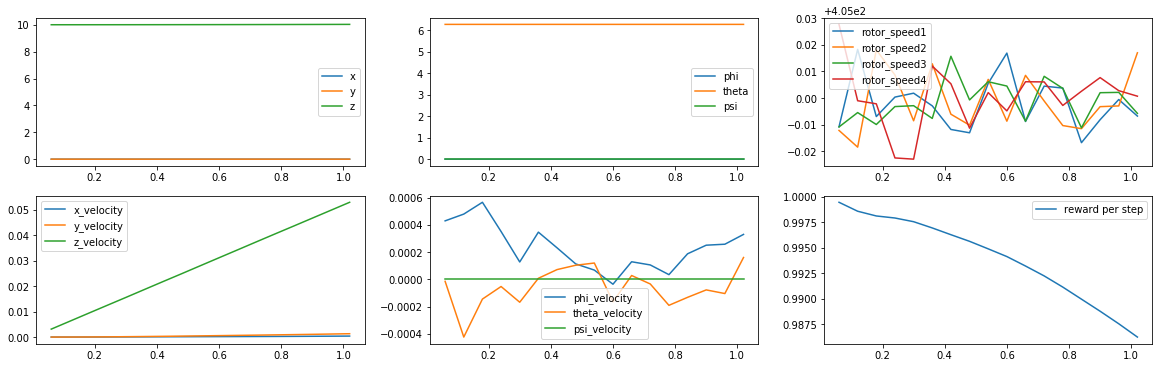

In [52]:
import plot_flight

plot_flight(best_flight)

The hover task is succcessfully accomplished since:

- the position is steady at the target position;
- the attitude is also steady and leveled;
- the linear and angular velocities are quite close to null; and
- rotor speeds are quite constant (do not forget to consider the *axis scale*).

## Lessons Learned
Testemonial from the author:
> "The hardest part of the project was to set the simulation to run faster. During my first weeks each episode was taking between 1 and 5 real seconds so my learning rate was not steep. A few days ago I finally realized that I should **first make the simulation faster** and only then move to improve the reinforcement learning agent.
>
>In order to speed the simulation up I had:
- returned the `action_repeat` from 1 back to 3;
- shortened the simulation `runtime` from 5 to 1 seconds (the flight would become ugly or beautiful in the first second anyway);
- commanded `learn` only when episodes are done instead of after every step (surprisingly it didn´t hurt the agent learning rate); and
- returned the `state` back to positions and attitudes only (instead of my traditional idea of observing also the velocities and accelerations).
>
>These fixings allowed me to run a thousand episodes in way less than a minute so **my learning rate increased considerably**. Only then, just a few days later, I finally managed to finish this project."